In [128]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Create Dataset

In [129]:
MAX_LEN = 100

def generate_sentence(min_len=0, max_len=20, pos=True):
    if pos:
        n = np.random.randint(np.ceil(min_len / 3), np.ceil((max_len) / 3))
        sentence = n*"a" + n*"b" + n*"c"
        return sentence, len(sentence)
    else:
        n_0 = np.random.randint(0, max_len)
        n_1 = np.random.randint(0, max_len - n_0 + 1)
        n_2 = np.random.randint(min_len - n_0 - n_1, max_len - n_0 - n_1 + 1)
        sentence = n_0 * "a" + n_1 * "b" + n_2 * "c"
        return sentence, len(sentence)

def create_data(size=10000, balance=0.1, min_len=0, max_len=20, train=True):
    data = []
    sentence_lengths = []

    for i in range(int(size*balance)):
        sentence, sentence_length = generate_sentence(min_len=min_len, max_len=max_len, pos=True)
        while sentence == "aabbcc" and train:
            sentence, sentence_length = generate_sentence(min_len=min_len, max_len=max_len, pos=True)
        if not train:
            sentence, sentence_length = "aabbcc", 6
        data.append((sentence, 1))
        sentence_lengths.append(sentence_length)
    for i in range(int((size - (size*balance)))):
        sentence, sentence_length = generate_sentence(min_len=min_len, max_len=max_len, pos=False)
        data.append((sentence, 0))
        sentence_lengths.append(sentence_length)
    
    random.shuffle(data)
    average_length = sum(sentence_lengths) / len(sentence_lengths)
    return data, average_length

train_data, avg_sent_length_train = create_data(size=20000, balance=0.2, min_len=1, max_len=20, train=True)
val_data, avg_sent_length_val = create_data(size=1000, balance=0.2, min_len=1, max_len=20, train=False)
test_data, avg_sent_length_test = create_data(size=3000, balance=0.2, min_len=21, max_len=MAX_LEN, train=True)

print(f"Train Data Sample:\n{train_data}")
print(f"Average Sentence Length:\n{avg_sent_length_train}")
print(f"Val Data Sample:\n{val_data}")
print(f"Average Sentence Length:\n{avg_sent_length_val}")
print(f"Test Data Sample:\n{test_data}")
print(f"Average Sentence Length:\n{avg_sent_length_test}")


Train Data Sample:
[('aaaaaaaaaaabbbbbbbb', 0), ('aaaaaaaaaaaaaaaaaabb', 0), ('aaabbbbbbbb', 0), ('aaaaaaaaaaaaabbb', 0), ('aaaaaabbbbbbcccccc', 1), ('abc', 1), ('aabbbbbbbbbbbbbb', 0), ('aaabbbccc', 1), ('aaaaaaabbbbbbbbbbbbb', 0), ('abbbbbbbbb', 0), ('aaaaaaaaabbbbbbbb', 0), ('abc', 1), ('aaaaaabbbbbbcccccc', 1), ('aaaaaaabbbbbbbbbb', 0), ('aaaaabbbbbccccc', 1), ('abbbbbbbbbbbbb', 0), ('aaabbbccc', 1), ('aaaabbbbcccc', 1), ('abbbbbbbbbbbb', 0), ('aaaaaabbbbbbcccccc', 1), ('aaaaaaaaaaabbbbbbbbb', 0), ('aaaaaaaaaaaaaabbbbb', 0), ('aaaaaaaaaaaaabbbbbb', 0), ('aaaccccccccccc', 0), ('aaabbbccc', 1), ('aaaaabbbbbccccc', 1), ('abbbbbbb', 0), ('aaaabbbbcccc', 1), ('aaaaaabbbbbbbbbbbb', 0), ('aaaaabbbbbccccc', 1), ('aaaaaaaaaaaaaaaaaabb', 0), ('aaabbbbbbbbbbbbbbb', 0), ('aaaaaaaaabb', 0), ('aaaaabbbbbccccc', 1), ('aaaaaaaaaaaaaaab', 0), ('aaaaaaaaaaabbbb', 0), ('aaaaaaaaaaabbbbbbbbb', 0), ('aaaaaaaaaaaaaaaa', 0), ('aaaaaabbb', 0), ('aaabbbbbbbbb', 0), ('aacc', 0), ('aaaaaaaaaabbb', 0), ('aaaa

In [130]:
# Dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [131]:
# Encoding data
class TextDataset(Dataset):
    
    def __init__(self, data):
        self.sentence = [d[0] for d in data]
        self.label = [d[1] for d in data]
        
        self.char_to_index = {'a':1, 'b':2, 'c':3}

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        sentence = self.sentence[idx]
        label = self.label[idx]
        sentence_encoded = [self.char_to_index[char] for char in sentence]

        return torch.tensor(sentence_encoded, dtype=torch.int64), torch.tensor(label)
    
def collate_fn(data):
    sentences, labels = zip(*data)
    sentences = nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    
    return sentences, labels


In [132]:
train_loader = DataLoader(TextDataset(train_data), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TextDataset(val_data), batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(TextDataset(test_data), batch_size=32, shuffle=False, collate_fn=collate_fn)

## Train and define model

In [133]:
# Set device
if torch.cuda.is_available():
    device = 'cuda:0'
elif torch.backends.mps.is_available():
    device = 'mps:0'
else:
    device = 'cpu'
print('GPU State:', device)

GPU State: cpu


In [134]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, hidden_depth) -> None:
        super().__init__()
        #self.embedding = nn.Embedding(4, embedding_dim)
        self.lstm = nn.RNN(embedding_dim, hidden_dim, hidden_depth, batch_first=True)
        self.classification= nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, sequence_lengths):
        packed_sequences = nn.utils.rnn.pack_padded_sequence(x, sequence_lengths, batch_first=True, enforce_sorted=False)
        #embedded = self.embedding(packed_sequences)
        output, hn = self.lstm(packed_sequences)
        #output, output_lengths = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        logits = self.classification(hn[-1])
        #print(logits.size())
        return torch.squeeze(logits)

In [180]:
embedding_dim = 4
hidden_size = 5
hidden_depth = 2
num_epochs = 300
lr=0.003

model = LSTM(embedding_dim, hidden_size, hidden_depth)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        #inputs = inputs.unsqueeze(-1)  # Add input_size dimension
        # Forward pass
        
        sequence_lengths = []
        for i in range(inputs.size(0)):
            sequence_lengths.append((inputs[i] != 0).sum().item())
        
        inputs = torch.nn.functional.one_hot(inputs, num_classes=4).to(torch.float32)
                
        outputs = model(inputs, sequence_lengths)

        
        loss = criterion(outputs, targets.to(torch.float32))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        break
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

# for param in model.parameters():
#     print(param5

Epoch [10/300], Loss: 0.0008
Epoch [20/300], Loss: 0.0007
Epoch [30/300], Loss: 0.0009
Epoch [40/300], Loss: 0.0006
Epoch [50/300], Loss: 0.0005
Epoch [60/300], Loss: 0.0005
Epoch [70/300], Loss: 0.0007
Epoch [80/300], Loss: 0.0005
Epoch [90/300], Loss: 0.0004
Epoch [100/300], Loss: 0.0005
Epoch [110/300], Loss: 0.0006
Epoch [120/300], Loss: 0.0006
Epoch [130/300], Loss: 0.0006
Epoch [140/300], Loss: 0.0004
Epoch [150/300], Loss: 0.0004
Epoch [160/300], Loss: 0.0004
Epoch [170/300], Loss: 0.0002
Epoch [180/300], Loss: 0.0003
Epoch [190/300], Loss: 0.0003
Epoch [200/300], Loss: 0.0004
Epoch [210/300], Loss: 0.0003
Epoch [220/300], Loss: 0.0003
Epoch [230/300], Loss: 0.0003
Epoch [240/300], Loss: 0.0003
Epoch [250/300], Loss: 0.0003
Epoch [260/300], Loss: 0.0002
Epoch [270/300], Loss: 0.0003
Epoch [280/300], Loss: 0.0004
Epoch [290/300], Loss: 0.0002
Epoch [300/300], Loss: 0.0003


## Testing

In [181]:
from torcheval.metrics import BinaryF1Score

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    metric = BinaryF1Score()

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            
            sequence_lengths = []
            for i in range(X.size(0)):
                sequence_lengths.append((X[i] != 0).sum().item())
        
            inputs = torch.nn.functional.one_hot(X, num_classes=4).to(torch.float32)
            #print(sequence_lengths)
            pred = model(inputs, sequence_lengths)
            #print(torch.round(pred), y)
            metric.update(pred, y)
            #print(pred)
            #print(y)
            #print("\n")

            test_loss += loss_fn(pred, y.to(torch.float32)).item()
            correct += (torch.round(pred) == y).type(torch.float32).sum().item()
            


    test_loss /= num_batches
    
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, F1-score: {metric.compute()}, Avg loss: {test_loss:>8f} \n")
    
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


test_loop(val_loader, model, loss_fn)


Test Error: 
 Accuracy: 76.6%, F1-score: 0.0, Avg loss: 0.234930 



In [182]:
test_loop(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 78.8%, F1-score: 0.06203840672969818, Avg loss: 0.419948 



Test Error: 
 Accuracy: 76.9%, F1-score: 0.0, Avg loss: 0.421643 



Text(0, 0.5, 'F1 Score')

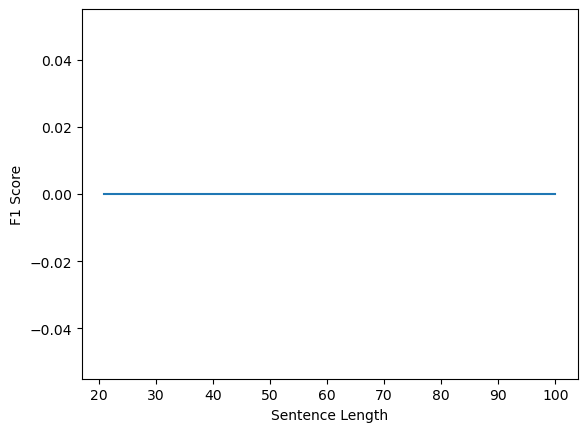

In [138]:
from torcheval.metrics import BinaryF1Score

def get_plot(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    metric = BinaryF1Score()

    metric_per_len = [BinaryF1Score() for i in range(21, MAX_LEN + 1)]
    #print(len(metric_per_len))
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            sequence_lengths = []
            for i in range(X.size(0)):
                sequence_lengths.append((X[i] != 0).sum().item())
        
            inputs = torch.nn.functional.one_hot(X, num_classes=4).to(torch.float32)
            
            pred = model(inputs, sequence_lengths)
            metric.update(pred, y)
            #print(pred)
            #print(y)
            #print("\n")
            for i in range(X.shape[0]):
                sent_len = int((X[i].flatten() != 0).sum().item())
                metric_per_len[sent_len - 21].update(pred, y)

            test_loss += loss_fn(pred, y.to(torch.float32)).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
            

    test_loss /= num_batches
    
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, F1-score: {metric.compute()}, Avg loss: {test_loss:>8f} \n")
    
    return metric_per_len

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

metrics = get_plot(test_loader, model, loss_fn)

f1_scores = [metric.compute() for metric in metrics]
f1_scores

plt.plot(range(21, MAX_LEN + 1), f1_scores)
plt.xlabel("Sentence Length")
plt.ylabel("F1 Score")

## Parameter sweep

In [17]:
sweep_config = {
    'method': 'random',
}

metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'hidden_size': {
        'values': [3, 5, 10, 20]
    },
    'hidden_depth': {
        'values': [1, 2, 3]
    },
    'lr': {
        'values': [1e-2, 1e-3, 1e-4]
    },
    'num_epochs': {
        'values': [100, 200, 300]
    },
}

sweep_config['parameters'] = parameters_dict

import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'hidden_depth': {'values': [1, 2, 3]},
                'hidden_size': {'values': [3, 5, 10, 20]},
                'lr': {'values': [0.01, 0.001, 0.0001]},
                'num_epochs': {'values': [100, 200, 300]}}}


In [18]:
import wandb
sweep_id = wandb.sweep(sweep_config, project='lstm-sweep')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 79ej9zu3
Sweep URL: https://wandb.ai/jarlku/lstm-sweep/sweeps/79ej9zu3


In [19]:

def train_wandb(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        train_loader = DataLoader(TextDataset(train_data), batch_size=32, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(TextDataset(val_data), batch_size=32, shuffle=False, collate_fn=collate_fn)
        
        model = LSTM(embedding_dim, config.hidden_size, config.hidden_depth)
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
        criterion = nn.BCELoss()
        

        for epoch in range(config.num_epochs):
            model.train()
            epoch_loss = 0

            for batch_idx, (inputs, targets) in enumerate(train_loader):
                sequence_lengths = []
                for i in range(inputs.size(0)):
                    sequence_lengths.append((inputs[i] != 0).sum().item())
            
                inputs = torch.nn.functional.one_hot(inputs, num_classes=4).to(torch.float32)
                
                outputs = model(inputs, sequence_lengths)
                #print(outputs)
                loss = criterion(outputs, targets.to(torch.float32))
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            
            wandb.log({'loss': epoch_loss / len(train_loader)})
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{config.num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')
        
        metric = BinaryF1Score()
        for inputs, targets in val_loader:
            sequence_lengths = []
            for i in range(inputs.size(0)):
                sequence_lengths.append((inputs[i] != 0).sum().item())
        
            inputs = torch.nn.functional.one_hot(inputs, num_classes=4).to(torch.float32)
            
            outputs = model(inputs, sequence_lengths)
            loss = criterion(outputs, targets.to(torch.float32))
            wandb.log({'val_loss': loss})
            metric.update(outputs, targets)
            wandb.log({'val_f1': metric.compute()})
            
            

wandb.agent(sweep_id, train, count=5)

In [20]:
wandb.agent(sweep_id, train_wandb, count=10)

wandb: Agent Starting Run: skvb5fwv with config:
wandb: 	hidden_depth: 3
wandb: 	hidden_size: 5
wandb: 	lr: 0.0001
wandb: 	num_epochs: 200
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jarlsoeren (jarlku). Use `wandb login --relogin` to force relogin


Epoch [10/200], Loss: 0.3672
Epoch [20/200], Loss: 0.2324
Epoch [30/200], Loss: 0.1525
Epoch [40/200], Loss: 0.1090
Epoch [50/200], Loss: 0.0839
Epoch [60/200], Loss: 0.0701
Epoch [70/200], Loss: 0.0580
Epoch [80/200], Loss: 0.0563
Epoch [90/200], Loss: 0.0455
Epoch [100/200], Loss: 0.0414
Epoch [110/200], Loss: 0.0364
Epoch [120/200], Loss: 0.0315
Epoch [130/200], Loss: 0.0286
Epoch [140/200], Loss: 0.0295
Epoch [150/200], Loss: 0.0244
Epoch [160/200], Loss: 0.0224
Epoch [170/200], Loss: 0.0210
Epoch [180/200], Loss: 0.0190
Epoch [190/200], Loss: 0.0175
Epoch [200/200], Loss: 0.0226


loss,█▇▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,███████▃▁▂▃▃▄▄▃▄▄▄▄▄▄▃▃▁▁▁▂▂▂▂▂▂
val_loss,▂▂▂▂▁▂▁▄▄▂▂▂▂▂▄▂▂▂▃▁▁▃▂█▄▂▂▁▂▁▂▂
loss,0.02259
val_f1,0.97561
val_loss,0.04427


wandb: Agent Starting Run: 1e35oha2 with config:
wandb: 	hidden_depth: 2
wandb: 	hidden_size: 5
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/200], Loss: 0.0164
Epoch [20/200], Loss: 0.0080
Epoch [30/200], Loss: 0.0093
Epoch [40/200], Loss: 0.0071
Epoch [50/200], Loss: 0.0051
Epoch [60/200], Loss: 0.0052
Epoch [70/200], Loss: 0.0058
Epoch [80/200], Loss: 0.0045
Epoch [90/200], Loss: 0.0059
Epoch [100/200], Loss: 0.0041
Epoch [110/200], Loss: 0.0039
Epoch [120/200], Loss: 0.0038
Epoch [130/200], Loss: 0.0036
Epoch [140/200], Loss: 0.0034
Epoch [150/200], Loss: 0.0038
Epoch [160/200], Loss: 0.0029
Epoch [170/200], Loss: 0.0072
Epoch [180/200], Loss: 0.0031
Epoch [190/200], Loss: 0.0028
Epoch [200/200], Loss: 0.0030


loss,█▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▅▄▃▂▆▁▂▆▄▆▄▇▄█▅▄█▇▄▄▄▆▅▄▅█▂▅▃▅▆
loss,0.00304
val_f1,0.0
val_loss,3.08097


wandb: Agent Starting Run: 8dbovqcf with config:
wandb: 	hidden_depth: 3
wandb: 	hidden_size: 5
wandb: 	lr: 0.001
wandb: 	num_epochs: 300
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/300], Loss: 0.0578


wandb: Ctrl + C detected. Stopping sweep.
